# Qudits VS qubits


<img src="https://rqc.ru/static/RQClogo_black_ru.png" alt="drawing" height="300">

## Annotation

The following notebook implements qudits VQC and qubit VQC

Author: Artem Kuzmichev, Quantum Research Scientist, RQC

## qudit-vqc package


In [ ]:
try:
    from qubit_variational_qc import *
    from qudit_depolarization_channels import *
    from qudit_gates import *
    from qudit_variational_qc import *

except ModuleNotFoundError:
    !git clone https://github.com/artem-phys/qudits-vqc.git --quiet
    !cd qudits-vqc
    !pip install -e qudits-vqc --quiet
    print('qudits-vqc succecefully installed. Run again')
    exit()

## imports and qudit configuration


We are going to study implementation of qudits for variational circuits. Since the real device we have in FIAN is two-qudit quantim computer with d=4 (ququarts), it appears reasonable to choose this specific value

In [ ]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

from tqdm import tqdm

import cirq
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
from cirq import PauliSum

In [ ]:
d = 4
n = 2

qudits = cirq.LineQid.range(n, dimension=d)
q0, q1 = qudits

print(qudits)

[cirq.LineQid(0, dimension=4), cirq.LineQid(1, dimension=4)]


##Qubit VQC

In [ ]:
p1 = 0.001 # single qubit
p2 = 0.01 # two qubit

In [ ]:
def qubit_rot_layer(qubits_, theta_list, phi_list, with_noise=False):
    """Yields parametrized single qubit rotations"""
    for i, qid in enumerate(qubits_):
        rot = QuditRGate(0, 1, theta_list[i], phi_list[i], dimension=2)
        yield rot.on(cirq.LineQid(i, dimension=2))
        if with_noise:
            yield cirq.DepolarizingChannel(p=p1, n_qubits=1).on(qid)


def qubit_rot_zz_layer(qubits_, theta, with_noise=False):
    """Yields parametrized two qudit rotation"""
    for i in range(len(qubits_)):
        for j in range(i + 1, len(qubits_)):
            yield cirq.ZZ(qubits_[i], qubits_[j]) ** theta
            if with_noise:
                yield cirq.DepolarizingChannel(p=p2, n_qubits=2).on(qubits_[i], qubits_[j])


def qubit_one_step(qubits_, theta_list, phi_list, two_qudit_theta, with_noise=False):
    """One variational step"""
    yield qubit_rot_layer(qubits_, theta_list, phi_list, with_noise=with_noise)

    yield qubit_rot_zz_layer(qubits_, two_qudit_theta, with_noise=with_noise)


def qubit_variational_qc(tl_, pl_, tqtl_, num_layers_, num_qubits_, measurement=False, with_noise=False):

    # two_qudits
    qubits_ = cirq.LineQid.range(num_qubits_, dimension=2)
    qc = cirq.Circuit()

    # qc.append([cirq.H(q) for q in qubits_], strategy=InsertStrategy.NEW_THEN_INLINE)

    for layer in range(num_layers_):
        qc.append(qubit_one_step(qubits_, tl_[layer], pl_[layer], tqtl_[layer], with_noise=with_noise), strategy=InsertStrategy.NEW_THEN_INLINE)

    if measurement:
        qc.append(cirq.measure(*qubits_, key='qubits'))

    return qc

Qubit Variational Ansatz


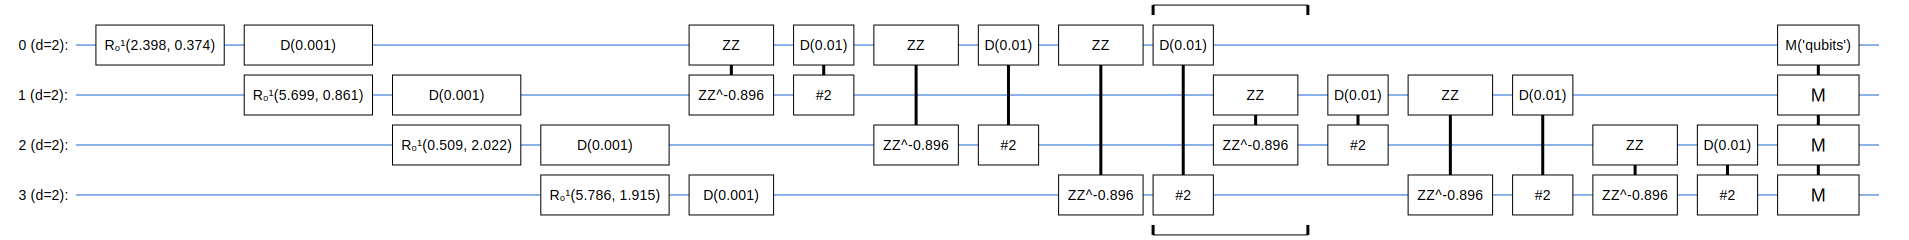

In [ ]:
num_layers = 1  # number of variational layers
num_qubits = 4
num_qubits_pairs = int((num_qubits + 1) * num_qubits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qubits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qubits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=num_layers)

print('Qubit Variational Ansatz')
qubit_vqc = qubit_variational_qc(tl, pl, tqtl, num_layers, num_qubits, measurement=True, with_noise=True)
SVGCircuit(qubit_vqc)

In [ ]:
simulator = cirq.DensityMatrixSimulator()

qubit_results = simulator.run(qubit_vqc, repetitions=10)
qubit_results.histogram(key='qubits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'1000': 8, '0110': 1, '1010': 1})

In [ ]:
qubit_energy_hist = qubit_results.histogram(key='qubits')
qubit_energy_hist

Counter({8: 8, 6: 1, 10: 1})

##Qudit VQC


Qudit Variational Ansatz


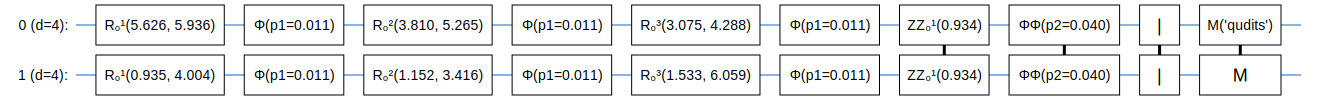

In [ ]:
num_layers = 1  # number of variational layers
num_qudits = 2
num_qudits_pairs = int((num_qudits + 1) * num_qudits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qudits_pairs))

print('Qudit Variational Ansatz')
qudit_vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=True, with_noise=True)
SVGCircuit(qudit_vqc)

In [ ]:
tl, pl, tqtl

(array([[[5.62564618, 0.93456053],
         [3.8096967 , 1.15235614],
         [3.07470915, 1.53343697]]]), array([[[5.93585063, 4.00392282],
         [5.26492683, 3.41582237],
         [4.2880093 , 6.05943299]]]), array([[0.9338966 , 2.80108715, 2.11674156]]))

In [ ]:
qudit_results = simulator.run(qudit_vqc, repetitions=10)
qudit_results.histogram(key='qudits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'22': 3, '23': 2, '20': 2, '21': 1, '03': 1, '13': 1})

##Reshape pararameters list

params = [0.23430288 5.0450009  5.26606643 5.80715436 6.01332705 4.21447036
 0.48545434 3.87137393 4.3867645 ]

theta_list = [[0.23430288 5.0450009  5.26606643 5.80715436]]
phi_list = [[6.01332705 4.21447036 0.48545434 3.87137393]]
tqt_list = [4.3867645]


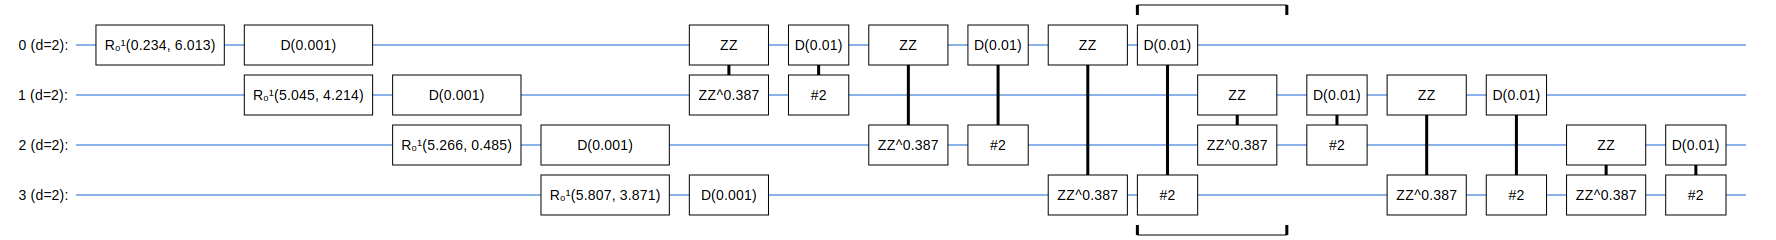

In [ ]:
def qubit_parameters_reshape(params):
        # Parameters reshape
        tl = np.array([params[:num_qubits]])
        pl = np.array([params[num_qubits : 2 * num_qubits]])
        tqtl = np.array([params[-1]])

        return tl, pl, tqtl

num_qubits = 4
num_layers = 1

params = np.random.uniform(low=0, high=2 * np.pi, size= num_qubits * 2 + 1)
print(f'params = {params}')
print()
tl, pl, tqtl = qubit_parameters_reshape(params)
print(f'theta_list = {tl}')
print(f'phi_list = {pl}')
print(f'tqt_list = {tqtl}')

qubit__vqc = qubit_variational_qc(tl, pl, tqtl, num_layers, num_qubits, measurement=False, with_noise=True)
SVGCircuit(qubit__vqc)

params = [2.31348044 4.1113846  0.43196307 3.04592165 0.33272112 2.07184627
 6.22024928 3.9496355  0.80517901 1.77978619 1.22422648 3.84799936
 4.21487598]

theta_list = [array([[2.31348044, 4.1113846 ],
       [0.43196307, 3.04592165],
       [0.33272112, 2.07184627]])]
phi_list = [array([[6.22024928, 3.9496355 ],
       [0.80517901, 1.77978619],
       [1.22422648, 3.84799936]])]
tqt_list = [array([4.21487598])]



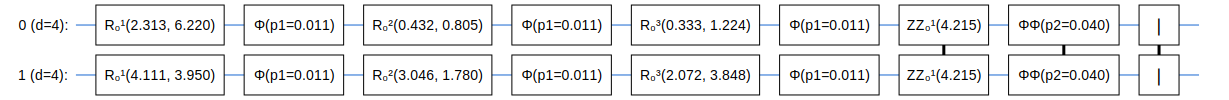

In [ ]:
def qudit_parameters_reshape(params):
    tl = [params[:num_qudits * 3].reshape((3, num_qudits))]
    pl = [params[num_qudits * 3:2 * num_qudits * 3].reshape((3, num_qudits))]
    tqtl = [params[2 * num_qudits * 3:]]

    return tl, pl, tqtl

num_qudits = 2
num_layers = 1

params = np.random.uniform(low=0, high=2 * np.pi, size= num_qudits * 6 + 1)
print(f'params = {params}')
print()
tl, pl, tqtl = qudit_parameters_reshape(params)
print(f'theta_list = {tl}')
print(f'phi_list = {pl}')
print(f'tqt_list = {tqtl}')
print()
qudit__vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=False, with_noise=True)
SVGCircuit(qudit__vqc)

## Ising problem instanse


\begin{equation}
    H =  - J\sum\limits_i {S_i^zS_{i + 1}^z - B\sum\limits_i {S_i^x} }
\end{equation}

\begin{equation}
    S = -1, 1
\end{equation}

\begin{equation}
    H =  - \frac{J}{4}\sum\limits_i {\sigma_i^z\sigma_{i + 1}^z - \frac{B}{2}\sum\limits_i {\sigma_i^x} }
\end{equation}

\begin{equation}
    \sigma = 0, 1
\end{equation}

Create Ising interaction matrix

In [ ]:
n_qubits = 4
qubits = [cirq.LineQubit(i) for i in range(n_qubits)]

J = np.zeros((n_qubits, n_qubits))

for i in range(n_qubits):
    J[i][(i + 1) % n_qubits] = -1 # np.random.rand()

J

array([[ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0.]])

Objective function that takes a list of variational parameters and returns Ising energy

In [ ]:
def ising_hamiltonian(B):    
    hamiltonian = 0
    for q in qubits:
        hamiltonian += -0.5 * complex(B) * cirq.X(q)
    for i1 in range(len(qubits)):
        hamiltonian += -0.25 * cirq.Z(qubits[i1]) * cirq.Z(qubits[(i1 + 1) % n_qubits])
    
    return hamiltonian

print(ising_hamiltonian(0))

-0.250*Z(q(0))*Z(q(1))-0.250*Z(q(1))*Z(q(2))-0.250*Z(q(2))*Z(q(3))-0.250*Z(q(0))*Z(q(3))


In [ ]:
initial_rho = np.zeros((16, 16))
initial_rho[0][0] += 1

In [ ]:
def objective_function(params, J, B, num_qubits, dimension, rho, show_qc=False, with_noise=True):

    if dimension == 2:
        tl, pl, tqtl = qubit_parameters_reshape(params)
        vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)

    elif dimension == 4:
        tl, pl, tqtl = qudit_parameters_reshape(params)
        vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)

    if show_qc:
        print(vqe_circuit)

    #Simulate
    rho = simulator.simulate(vqe_circuit, initial_state=initial_rho).final_density_matrix
    qmap = {q:i for i, q in enumerate(qubits)}
    expectation = ising_hamiltonian(B).expectation_from_density_matrix(rho, qmap).real

    return expectation / 4

qubits

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
num_layers = 1  # number of variational layers
num_qubits = 4
dimension = 2

B = 0
params = np.random.uniform(low=0, high=2 * np.pi, size= num_qubits * 2 + 1)
objective_function(params, J, B, num_qubits, dimension, initial_rho, show_qc=True)

                                                                                                                                                    ┌────────────────┐
0 (d=2): ───R₀¹(1.101, 3.699)───D(0.001)────────────────────────────────────────────────────ZZ──────────D(0.01)───ZZ──────────D(0.01)───ZZ───────────D(0.01)───────────────────────────────────────────────────────────────────
                                                                                            │           │         │           │         │            │
1 (d=2): ───────────────────────R₀¹(0.232, 0.871)───D(0.001)────────────────────────────────ZZ^-0.103───#2────────┼───────────┼─────────┼────────────┼──────ZZ───────────D(0.01)───ZZ──────────D(0.01)─────────────────────────
                                                                                                                  │           │         │            │      │            │         │           │
2 (d=2): ────────────────────────────────

0.008931947872042656

qudits

In [ ]:
num_layers = 1
num_qudits = 2
dimension = 4

B = 0
params = np.random.uniform(low=0, high=2 * np.pi, size= num_qudits * 6 + 1)
objective_function(params, J, B, num_qudits, dimension, initial_rho, show_qc=True)

0 (d=4): ───R₀¹(2.505, 3.990)───Φ(p1=0.011)───R₀²(3.815, 1.686)───Φ(p1=0.011)───R₀³(3.959, 3.471)───Φ(p1=0.011)───ZZ₀¹(1.731)───ΦΦ(p2=0.040)───|───
                                                                                                                  │             │              │
1 (d=4): ───R₀¹(0.356, 4.581)───Φ(p1=0.011)───R₀²(4.943, 5.095)───Φ(p1=0.011)───R₀³(4.397, 5.486)───Φ(p1=0.011)───ZZ₀¹(1.731)───ΦΦ(p2=0.040)───|───


0.014276204630732536

##Optimization - Noise

In [ ]:
def corrected_rho(A):

    # hermitize
    B = (A + A.conj().T) / 2

    # add positive definiteness
    C = B + 1e-6 * np.identity(len(B)) 

    # correct trace
    D = C / np.trace(C)

    return D

### Exact numerical solution

VQE train function

In [ ]:
def train(b_field, max_layers, n_qubits, dimension, n_initial, verbose=False, with_noise=False):
    
    layers_energy = []
    rho = initial_rho
    
    for layer in range(1, max_layers + 1):

        cost_energy = []
        angles = []

        for ii in range(n_initial):
            #print counter
            if verbose:
                print()
                print(f'Layer = {layer}, random initizalization {ii}')
            
            # randomly initialize variational parameters within appropriate bounds
            np.random.seed(ii)
            if dimension == 2:
                params_size = num_qubits * 2 + 1
            elif dimension == 4:
                params_size = num_qudits * 6 + 1
            
            #initial params
            if ii == 0:
                params0 = np.zeros(params_size).tolist()
            else:
                params0 = np.random.uniform(low=0, high=2 * np.pi, size=params_size).tolist()

            bnds = [(0, 2 * np.pi) for _ in range(int(len(params0)))]

            # run classical optimization
            if dimension == 2:
                result = minimize(objective_function, params0, args=(J, b_field, num_qubits, dimension, rho), 
                            method='Powell', bounds=bnds, options={'maxiter': 100})
            elif dimension == 4:
                result = minimize(objective_function, params0, args=(J, b_field, num_qudits, dimension, rho), 
                            method='Powell', bounds=bnds, options={'maxiter': 100})
            

            # store result of classical optimization
            result_energy = result.fun
            cost_energy.append(result_energy)
            result_angle = result.x
            angles.append(result_angle)
            if verbose:
                print('Optimal avg energy:', result_energy)
                print('Optimal angles:', result_angle)
                print()
        
        # store energy minimum (over different initial configurations)
        energy_min = np.min(cost_energy)
        optim_angles = angles[np.argmin(cost_energy)]
        if verbose:
            print()
            print('Energy per initial seeds:', cost_energy)
            print('Best energy:', energy_min)
            print('Best angles:', optim_angles)
            print()
        
        layers_energy.append(energy_min)
        
        # Parameters reshape
        if dimension == 2:
            tl, pl, tqtl = qubit_parameters_reshape(optim_angles)
            vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)
        elif dimension == 4:
            tl, pl, tqtl = qudit_parameters_reshape(optim_angles)
            vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)
        
        # VQE circuit simulation-
        rho = simulator.simulate(vqe_circuit, initial_state=rho).final_density_matrix

        print('Not corrected')
        print(f'trace_rho = {np.trace(rho)}')
        print(f'np.max(rho - rho.conj().T) = {np.max(rho - rho.conj().T)}')
        print(f'eigval_rho = {np.linalg.eig(rho)[0]}')

        rho = corrected_rho(rho)

        print('Corrected')
        print(f'trace_rho = {np.trace(rho)}')
        print(f'np.max(rho - rho.conj().T) = {np.max(rho - rho.conj().T)}')
        print(f'eigval_rho = {np.linalg.eig(rho)[0]}')
        
    return layers_energy

Some settings

In [ ]:
max_layers = 3
n_initial = 4
verbose = False

Linspace of B values for optimization

In [ ]:
B_values = 2 ** np.linspace(0, 3, 10) - 1
B_values

array([0.        , 0.25992105, 0.58740105, 1.        , 1.5198421 ,
       2.1748021 , 3.        , 4.0396842 , 5.34960421, 7.        ])

We can numerically solve for GS energy of TIM

In [ ]:
def exact_solution(B):

    if B == 0:
        return -0.25

    l_value = 1 / (2 * B)
    gs_energy = 0
    
    # numerical integration
    step_size = 0.0001
    k_values = np.arange(0, np.pi, step_size)
    integration_values = [step_size * np.sqrt(1 + l_value ** 2 + 2 * l_value * np.cos(ki)) for ki in k_values]
    integral = np.sum(integration_values)
    gs_energy = 1 * integral / (4 * np.pi*l_value)
    
    return -1 * gs_energy

In [ ]:
results_exact = [exact_solution(B) for B in B_values]

### Classical optimization qubits d = 2
 

In [ ]:
num_qubits = 4
dimension = 2

In [ ]:
variational_results = []

for B in B_values:
    result = train(B, max_layers, num_qubits, dimension, n_initial,
                verbose=verbose)
    variational_results.append(result)

    print(f'B = {B}')
    print(result)
    print()

Not corrected
trace_rho = (1.000000238418579-5.960464477539063e-08j)
np.max(rho - rho.conj().T) = (7.275957614183426e-12+0j)
eigval_rho = [ 1.6071485e-33+0.0000000e+00j  1.0000004e+00-5.9604645e-08j
  4.2910100e-15-9.3918145e-16j  4.4183184e-16-1.1989835e-15j
 -3.1919508e-16+5.3709348e-16j  9.2811973e-16+1.5357707e-16j
  7.1452282e-23-1.9049558e-23j -4.1481405e-23+1.6046194e-23j
  1.7806160e-23-1.6551951e-23j -6.4041819e-24-1.7455173e-24j
  2.7703036e-24+4.7234194e-24j  1.9596299e-24-2.8651006e-26j
  1.8441901e-28-2.0010206e-28j  1.8329748e-31-1.6049907e-31j
 -2.0460241e-31-2.7010929e-32j -1.0887174e-31-8.8495035e-32j]
Corrected
trace_rho = (0.9999999999999999+0j)
np.max(rho - rho.conj().T) = 0j
eigval_rho = [9.99983702e-07+0.00000000e+00j 9.99985000e-01+1.91511307e-17j
 9.99983708e-07-2.79407097e-23j 9.99983703e-07-3.01044807e-23j
 9.99983701e-07-1.51692284e-23j 9.99983702e-07-1.23472527e-22j
 9.99983702e-07-2.62087146e-23j 9.99983702e-07-3.97046694e-23j
 9.99983702e-07-4.30133919e-23

### Classical optimization qudits d = 4
 

In [ ]:
num_qudits = 2
dimension = 4

In [ ]:
qudit_variational_results = []

for B in B_values:
    result = train(B, max_layers, num_qudits, dimension, n_initial,
                verbose=verbose)
    qudit_variational_results.append(result)

    print(f'B = {B}')
    print(result)
    print()

Not corrected
trace_rho = (1-1.7763568394002505e-15j)
np.max(rho - rho.conj().T) = (7.105427357601002e-15+7.105427357601002e-15j)
eigval_rho = [ 1.0000002e+00-4.7885584e-22j  2.2814846e-14-4.5868384e-15j
 -1.8525552e-14+1.5404434e-15j  3.3925626e-15+3.5609194e-16j
 -3.5585379e-15+8.5224146e-16j -1.4047632e-15+4.4894688e-17j
  9.7654090e-16+1.6810006e-17j -1.2268290e-21+3.7903590e-22j
  1.0622088e-21+1.1955959e-22j -2.8702975e-22+4.0896070e-23j
  2.7424995e-22+7.3511802e-23j  2.1013264e-22+4.4820350e-23j
  1.0484480e-22+2.7781888e-24j -1.8384386e-22-3.1459249e-23j
 -7.6108568e-23-3.1378076e-24j -6.3467097e-23+5.3791636e-24j]
Corrected
trace_rho = (1.0000000000000004+0j)
np.max(rho - rho.conj().T) = 0j
eigval_rho = [9.99985000e-01-4.97232966e-23j 9.99983811e-07-1.25186677e-22j
 9.99983769e-07+1.35574500e-22j 9.99983792e-07+5.91531111e-23j
 9.99983784e-07-2.58160251e-23j 9.99983787e-07+1.11280909e-22j
 9.99983789e-07-6.22340888e-23j 9.99983788e-07+6.61744490e-24j
 9.99983788e-07+9.7607312

##Result log

In [ ]:
variational_results_filename = "noisy_variational_results.csv"
qudit_variational_results_filename = "noisy_qudit_variational_results.csv"

In [ ]:
np.savetxt(variational_results_filename, variational_results, delimiter=",")
np.savetxt(qudit_variational_results_filename, qudit_variational_results, delimiter=",")

In [ ]:
variational_results = np.genfromtxt(variational_results_filename, delimiter=',')

qudit_variational_results = np.genfromtxt(qudit_variational_results_filename, delimiter=',')

## Comparison of exact and variational solutions

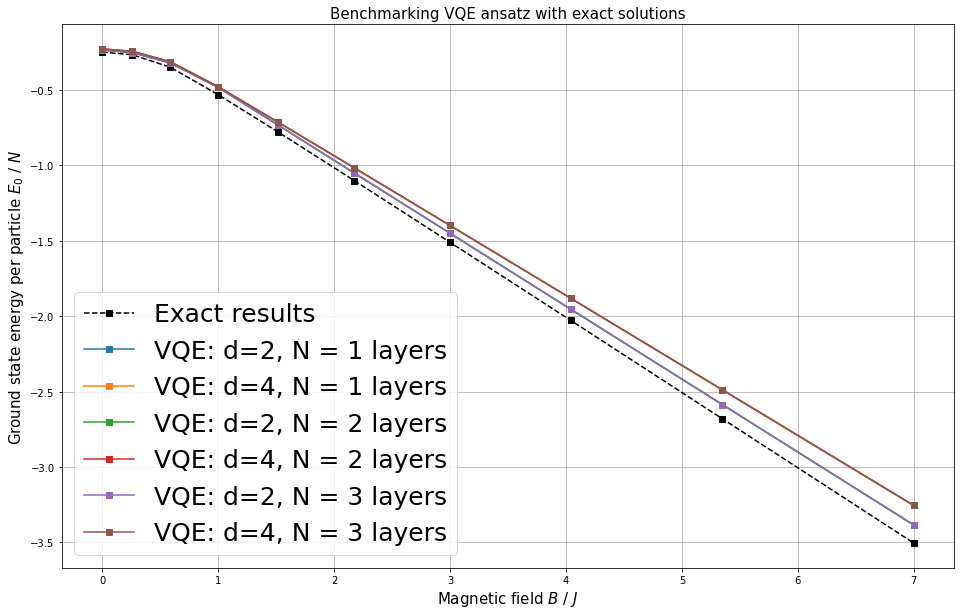

In [ ]:
plt.figure(figsize=(16, 10))

plt.plot(B_values, results_exact, 'k--s', label='Exact results')

for n_layers in range(1, max_layers + 1):
    plt.plot(B_values, [result[n_layers - 1] for result in variational_results], '-s', label=f'VQE: d=2, N = {n_layers} layers')
    plt.plot(B_values, [result[n_layers - 1] for result in qudit_variational_results], '-s', label=f'VQE: d=4, N = {n_layers} layers')

plt.title('Benchmarking VQE ansatz with exact solutions', fontsize=15)
plt.xlabel(r'Magnetic field $B$ / $J$ ', fontsize=15)
plt.ylabel('Ground state energy per particle $E_{0}$ / $N$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('noisy_vqe_qubits.png')

Relative error of VQE algorithm

\begin{equation}
    \eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|
\end{equation}

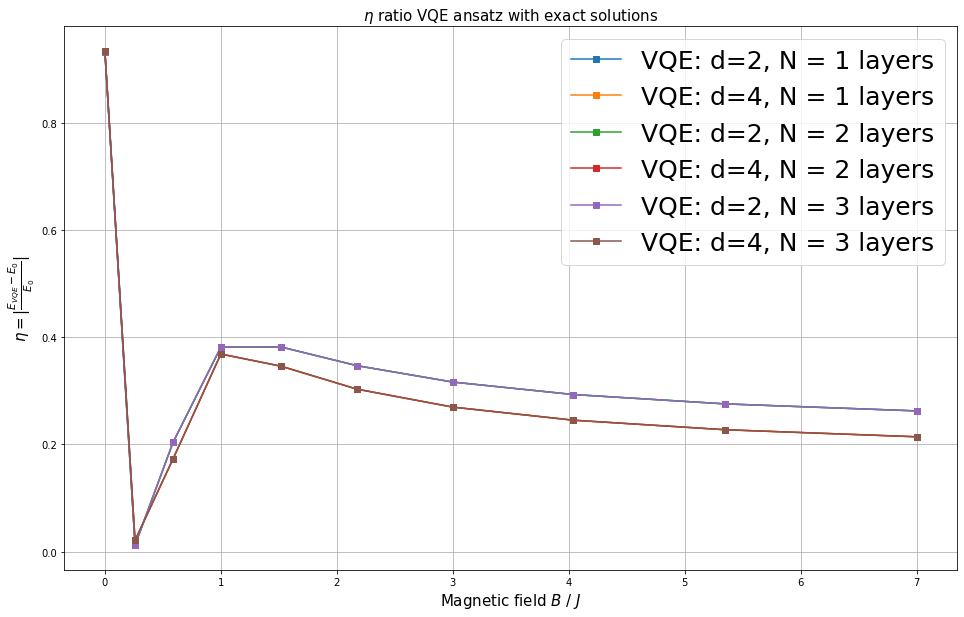

In [ ]:
plt.figure(figsize=(16, 10))

for n_layers in range(1, max_layers + 1):
    qubit_eta = []
    for i in range(len(B_values)):
        qubit_eta = qubit_eta + [np.abs(([result[n_layers - 1] for result in variational_results][i] - results_exact[i - 1]) / results_exact[i - 1]) ]
    plt.plot(B_values, qubit_eta, '-s', label=f'VQE: d=2, N = {n_layers} layers')


    qudit_eta = []
    for i in range(len(B_values)):
        qudit_eta = qudit_eta + [np.abs(([result[n_layers - 1] for result in qudit_variational_results][i] - results_exact[i - 1]) / results_exact[i - 1]) ]
    plt.plot(B_values, qudit_eta, '-s', label=f'VQE: d=4, N = {n_layers} layers')

plt.title(r'$\eta$ ratio VQE ansatz with exact solutions', fontsize=15)
plt.xlabel(r'Magnetic field $B$ / $J$ ', fontsize=15)
plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('noisy_vqe_eta.png')

### Layerwise progress:



In [ ]:
B_value_index = 5

In [ ]:
qubit_layer_score = []

for result in variational_results[B_value_index]:
    eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
    qubit_layer_score.append(eta)

qudit_layer_score = []

for result in qudit_variational_results[B_value_index]:
    eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
    qudit_layer_score.append(eta)


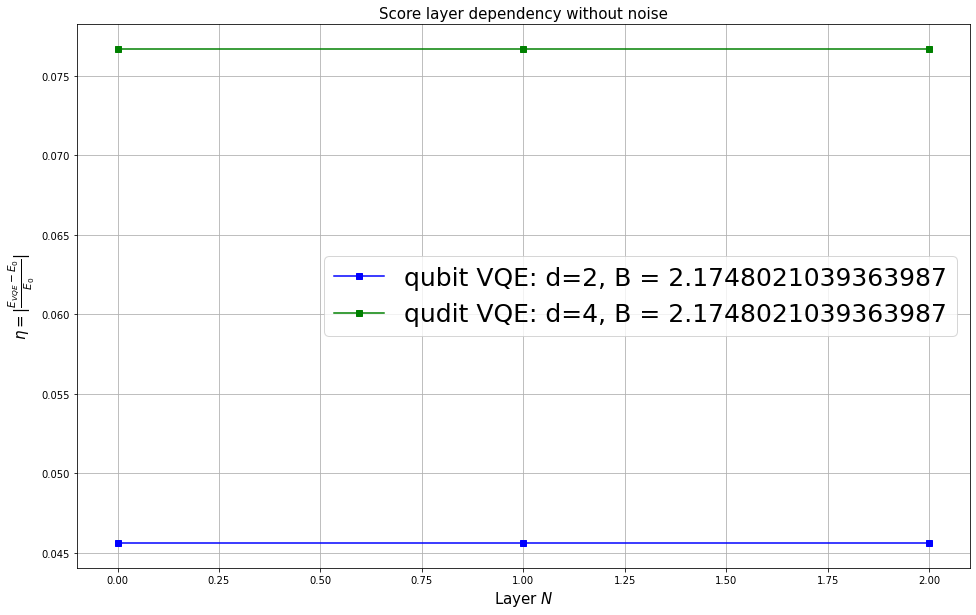

In [ ]:
plt.figure(figsize=(16, 10))

x = list(range(len(qubit_layer_score)))

plt.plot(x, qubit_layer_score, '-sb', label=f'qubit VQE: d=2, B = {B_values[B_value_index]}')
plt.plot(x, qudit_layer_score, '-sg', label=f'qudit VQE: d=4, B = {B_values[B_value_index]}')

plt.title(r'Score layer dependency without noise', fontsize=15)
plt.xlabel(r'Layer $N$', fontsize=15)
plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('noisy_score_layer_dependency.png')

### Layerwise loop 

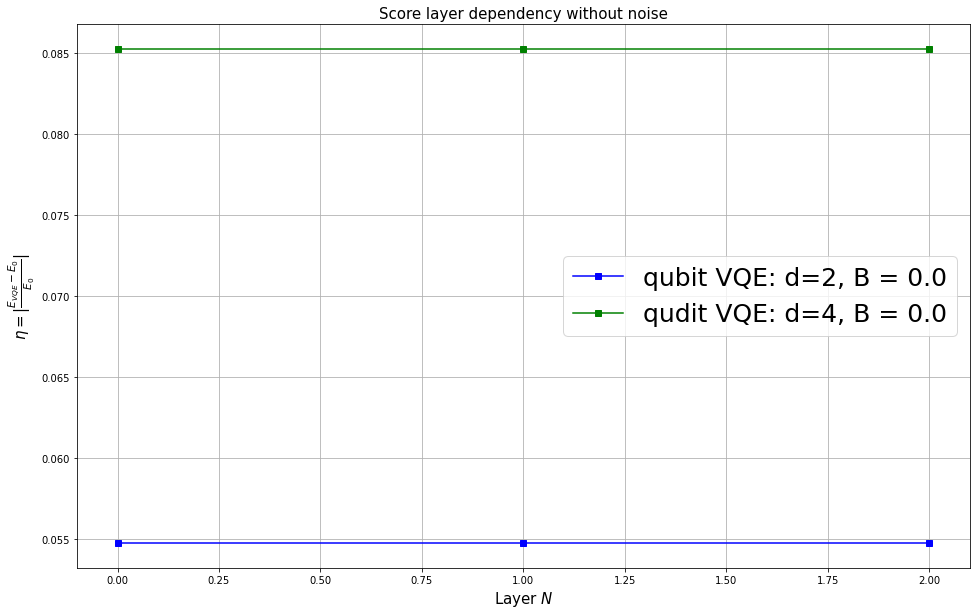

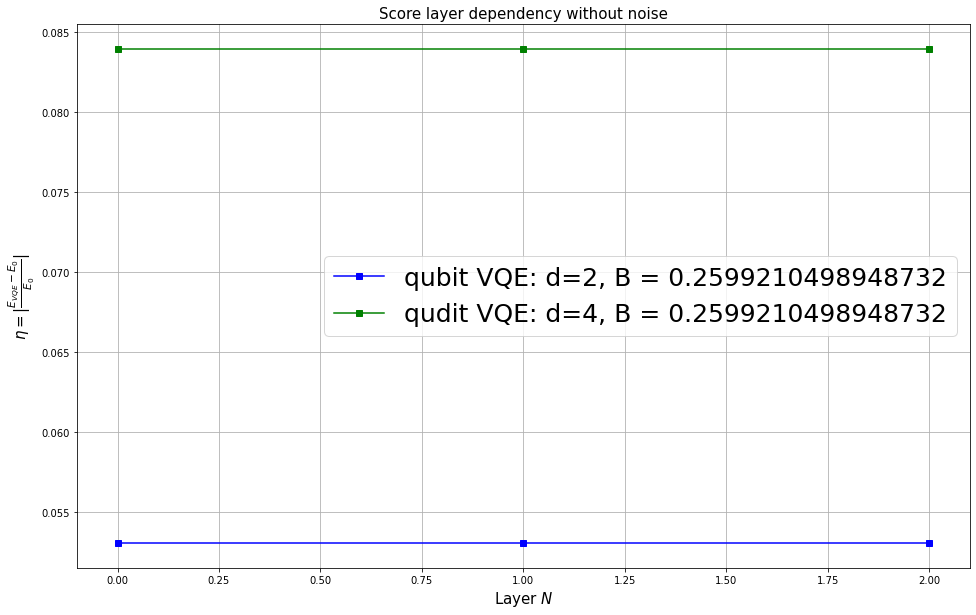

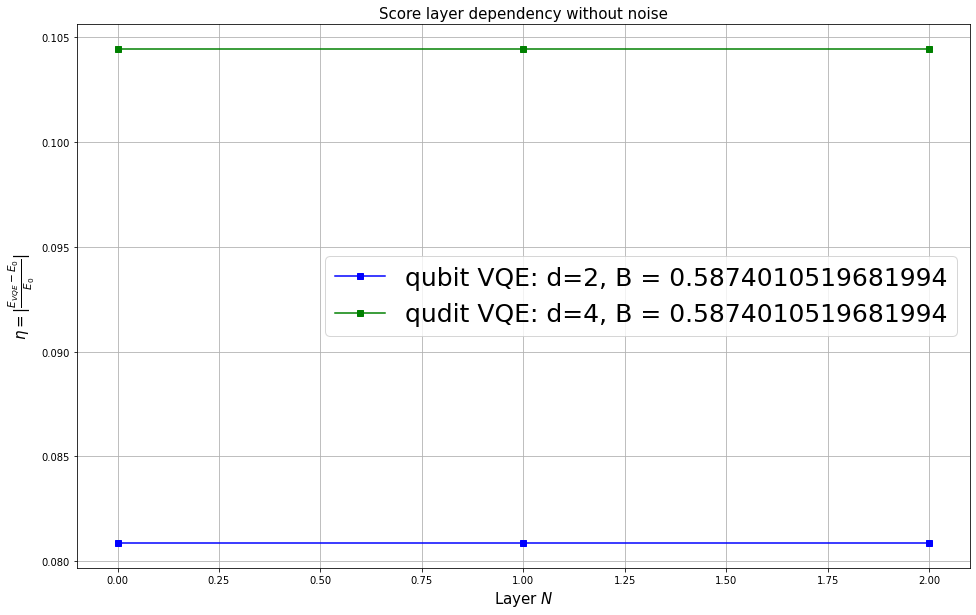

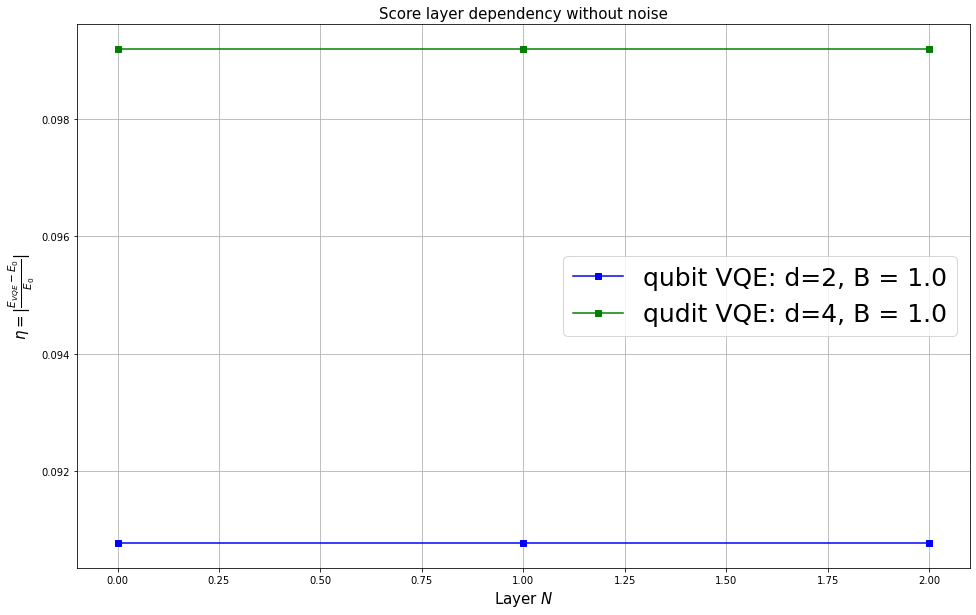

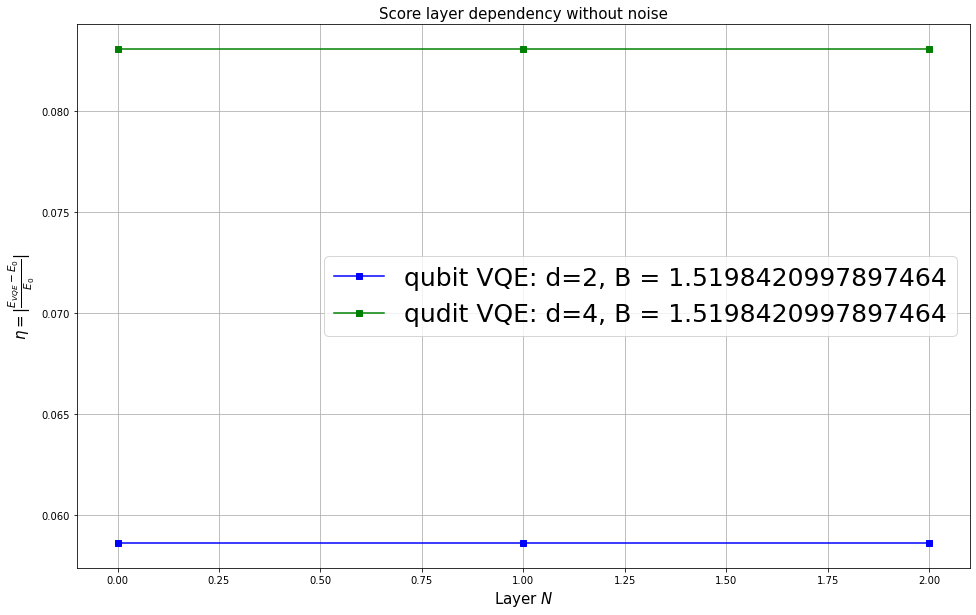

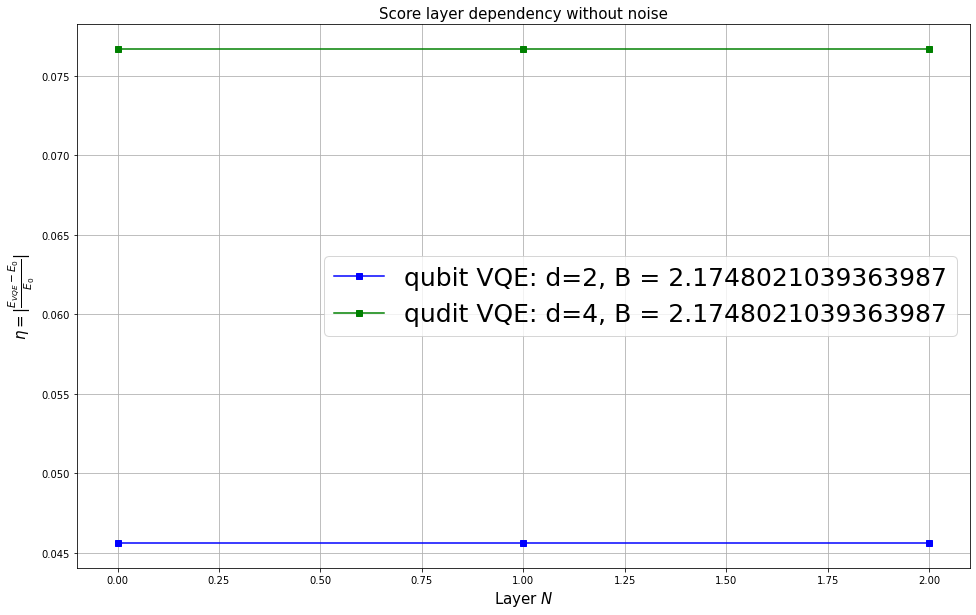

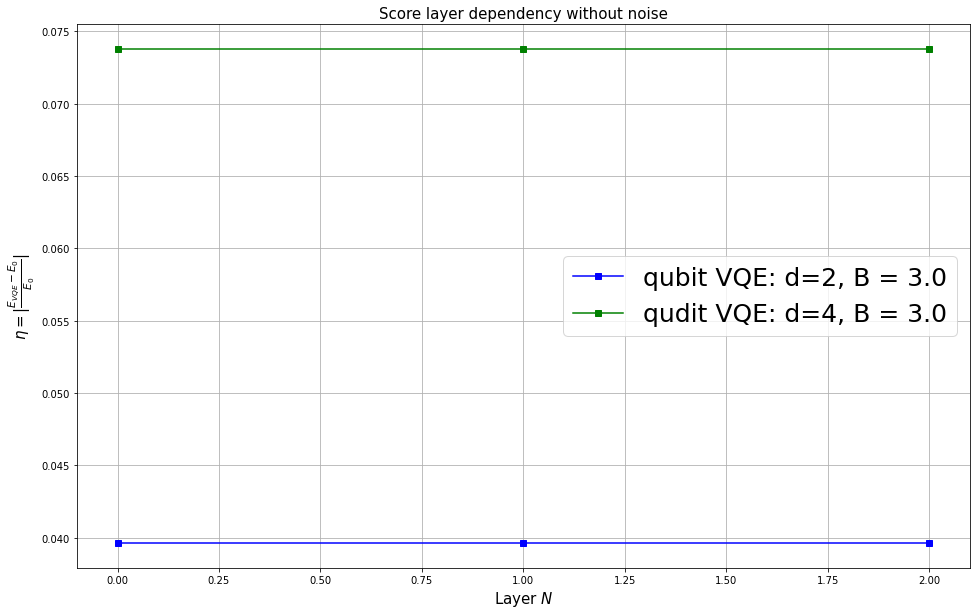

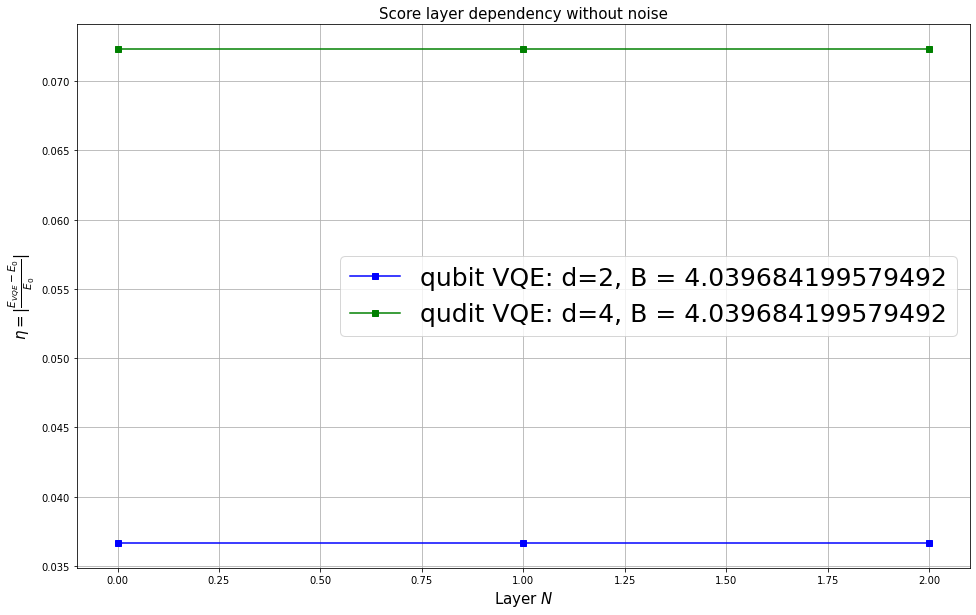

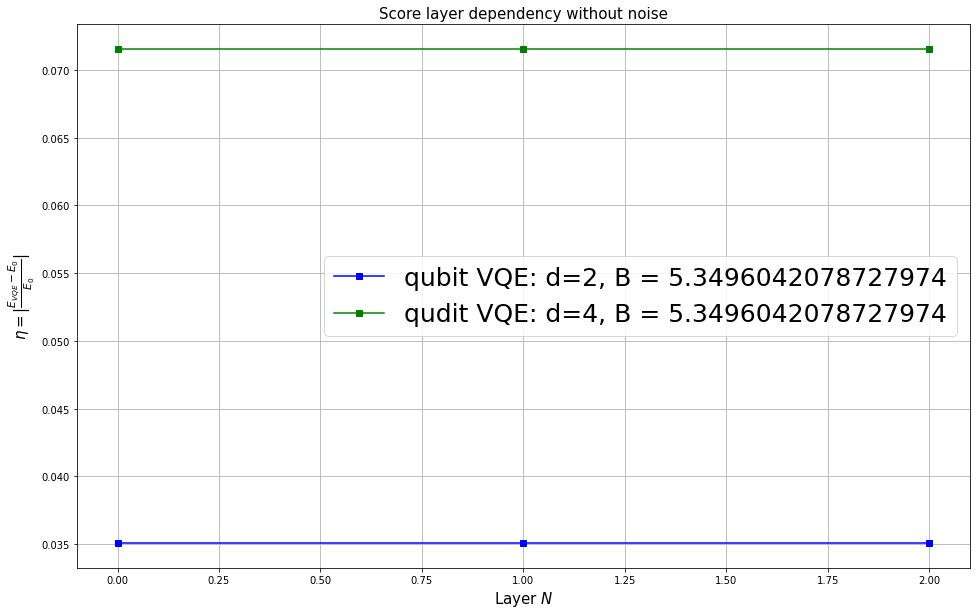

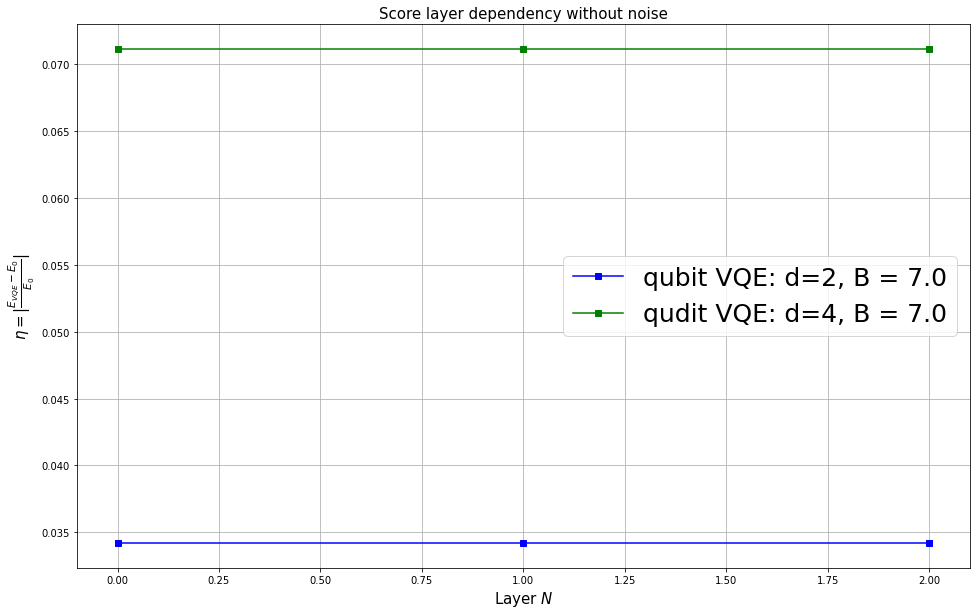

In [ ]:
for B_value_index in range(len(B_values)):
    qubit_layer_score = []

    for result in variational_results[B_value_index]:
        eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
        qubit_layer_score.append(eta)

    qudit_layer_score = []

    for result in qudit_variational_results[B_value_index]:
        eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
        qudit_layer_score.append(eta)


    plt.figure(figsize=(16, 10))

    x = list(range(len(qubit_layer_score)))

    plt.plot(x, qubit_layer_score, '-sb', label=f'qubit VQE: d=2, B = {B_values[B_value_index]}')
    plt.plot(x, qudit_layer_score, '-sg', label=f'qudit VQE: d=4, B = {B_values[B_value_index]}')

    plt.title(r'Score layer dependency without noise', fontsize=15)
    plt.xlabel(r'Layer $N$', fontsize=15)
    plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
    plt.grid()
    plt.legend(fontsize=25)

##Single parameter dependence

In [ ]:
def train_with_parameters_saved(b_field, max_layers, n_qubits, dimension, n_initial, verbose=False, with_noise=False):
    
    layers_energy = []
    layers_parameters = []

    rho = initial_rho
    
    for layer in range(1, max_layers + 1):

        cost_energy = []
        angles = []

        for ii in range(n_initial):
            #print counter
            if verbose:
                print()
                print(f'Layer = {layer}, random initizalization {ii}')
            
            # randomly initialize variational parameters within appropriate bounds
            np.random.seed(ii)
            if dimension == 2:
                params_size = num_qubits * 2 + 1
            elif dimension == 4:
                params_size = num_qudits * 6 + 1
            
            #initial params
            if ii == 0:
                params0 = np.zeros(params_size).tolist()
            else:
                params0 = np.random.uniform(low=0, high=2 * np.pi, size=params_size).tolist()

            bnds = [(0, 2 * np.pi) for _ in range(int(len(params0)))]

            # run classical optimization
            if dimension == 2:
                result = minimize(objective_function, params0, args=(J, b_field, num_qubits, dimension, rho), 
                            method='Powell', bounds=bnds, options={'maxiter': 100})
            elif dimension == 4:
                result = minimize(objective_function, params0, args=(J, b_field, num_qudits, dimension, rho), 
                            method='Powell', bounds=bnds, options={'maxiter': 100})
            

            # store result of classical optimization
            result_energy = result.fun
            cost_energy.append(result_energy)
            result_angle = result.x
            angles.append(result_angle)
            if verbose:
                print('Optimal avg energy:', result_energy)
                print('Optimal angles:', result_angle)
                print()
        
        # store energy minimum (over different initial configurations)
        energy_min = np.min(cost_energy)
        optim_angles = angles[np.argmin(cost_energy)]
        if verbose:
            print()
            print('Energy per initial seeds:', cost_energy)
            print('Best energy:', energy_min)
            print('Best angles:', optim_angles)
            print()
        
        layers_energy.append(energy_min)
        layers_parameters.append(optim_angles)
        
        # Parameters reshape
        if dimension == 2:
            tl, pl, tqtl = qubit_parameters_reshape(optim_angles)
            vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)
        elif dimension == 4:
            tl, pl, tqtl = qudit_parameters_reshape(optim_angles)
            vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)
        
        # VQE circuit simulation-
        rho = simulator.simulate(vqe_circuit, initial_state=rho).final_density_matrix

        print('Not corrected')
        print(f'trace_rho = {np.trace(rho)}')
        print(f'np.max(rho - rho.conj().T) = {np.max(rho - rho.conj().T)}')
        print(f'eigval_rho = {np.linalg.eig(rho)[0]}')

        rho = corrected_rho(rho)

        print('Corrected')
        print(f'trace_rho = {np.trace(rho)}')
        print(f'np.max(rho - rho.conj().T) = {np.max(rho - rho.conj().T)}')
        print(f'eigval_rho = {np.linalg.eig(rho)[0]}')
        
    return layers_energy, layers_parameters

In [ ]:
B = 7
max_layers = 2
num_qubits = 4
dimension = 2
n_initial = 3
verbose = True

single_result_energy, single_result_parameters = train_with_parameters_saved(B, max_layers, num_qubits, dimension, n_initial, verbose=verbose)

In [ ]:
single_result_parameters

[array([1.57040228, 1.57006157, 1.57057826, 4.712224  , 1.57073271,
        1.5709609 , 1.57065061, 4.71219438, 3.99993382]),
 array([1.57040228, 1.57006157, 1.57057826, 4.712224  , 1.57073271,
        1.5709609 , 1.57065061, 4.71219438, 3.99993382])]

output

In [ ]:
base_vqc = qubit_variational_qc(*qubit_parameters_reshape(single_result_parameters[0]), 1, 4)

for i in range(1, len(single_result_parameters) - 1):
    base_vqc.append(qubit_variational_qc(*qubit_parameters_reshape(single_result_parameters[i]), 1, 4))

base_vqc

┌────────┐
0 (d=2): ───R₀¹(1.570, 1.571)───ZZ─────ZZ──────ZZ────────────────────────
                                │      │       │
1 (d=2): ───R₀¹(1.570, 1.571)───ZZ^0───┼───────┼───ZZ──────ZZ────────────
                                       │       │   │       │
2 (d=2): ───R₀¹(1.571, 1.571)──────────ZZ^0────┼───ZZ^0────┼──────ZZ─────
                                               │           │      │
3 (d=2): ───R₀¹(4.712, 4.712)──────────────────ZZ^0────────ZZ^0───ZZ^0───
                                              └────────┘

In [ ]:
sv_optimal = simulator.simulate(base_vqc).final_state_vector
ising_hamiltonian(B).expectation_from_state_vector(sv_optimal, qmap).real / 4

AttributeError: ignored

In [ ]:
for par_number in range(len(optimal)):

    optimal = np.copy(single_result_parameters[-1])
    optimal_energy = single_result_energy[-1]

    number_points = 11
    optimal_par = optimal[par_number]

    x = optimal_par * np.ones(number_points) + np.linspace(-np.pi / 2, np.pi / 2, number_points)
    y = []

    for parameter0 in x:
        optimal[par_number] = parameter0

        last_layer = qubit_variational_qc(*qubit_parameters_reshape(optimal), 1, 4)

        vqc_optimal = base_vqc.copy()
        vqc_optimal.append(last_layer)

        sv_optimal = simulator.simulate(vqc_optimal).final_state_vector
        qmap = {q:i for i, q in enumerate(qubits)}
        expectation = ising_hamiltonian(B).expectation_from_state_vector(sv_optimal, qmap).real / 4

        y.append(expectation)


    plt.figure(par_number)
    plt.title(f'SPD for {par_number}-th parameter', fontsize=15)
    plt.xlabel(f'theta_{par_number}', fontsize=15)
    plt.ylabel(f'$E$', fontsize=15)
    plt.grid()
    plt.plot(x, y, '-s', label=f'123')
    plt.axvline(optimal_par, color ='red')
    plt.axhline(optimal_energy, color ='green')